In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#all business data files into a list
csv_files = ['../capstone_data/beer/BP_2012_00CZ2_with_ann.csv', '../capstone_data/beer/BP_2013_00CZ2_with_ann.csv','../capstone_data/beer/BP_2014_00CZ2_with_ann.csv', '../capstone_data/beer/BP_2015_00CZ2_with_ann.csv', '../capstone_data/beer/BP_2016_00CZ2_with_ann.csv']

#load all files into list of frames
frames = []
for csv in csv_files:
    df=pd.read_csv(csv)
    frames.append(df)

#concatenate frames into one DataFrame
business = pd.concat(frames)
print('business df created with shape:', business.shape)

business['YEAR.id'] = business['YEAR.id'].astype(str)


#set number of establishments as numeric
business['ESTAB']=business['ESTAB'].apply(pd.to_numeric, errors = 'coerce')

#shorten column names
business = business[business['EMPSZES.display-label']!='Meaning of Employment size of establishment']
rename = {'All establishments': 'All', 'Establishments with 1 to 4 employees':'1 to 4', 'Establishments with 5 to 9 employees':'5 to 9', 'Establishments with 10 to 19 employees':'10 to 19', 'Establishments with 20 to 49 employees':'20 to 49', 'Establishments with 50 to 99 employees':'50 to 99', 'Establishments with 100 to 249 employees':'100 to 249', 'Establishments with 250 to 499 employees':'250 to 499', 'Establishments with 500 to 999 employees':'500 to 999', 'Establishments with 1,000 employees or more':'1,000 plus'}
business = business.replace(rename)

#drop unnecessary columns
business = business.drop(columns = ['GEO.id', 'NAICS.id','EMPSZES.id'])

#columns to drop after re-aggregated
drop_later =  list(business['EMPSZES.display-label'].unique())
del drop_later[0]

#create pivot table that aggregates the number of establishments by year, zipcode, and business type
business_pvt = pd.pivot_table(business,values='ESTAB', index=['YEAR.id', 'GEO.id2', 'NAICS.display-label'], 
                              columns = ['EMPSZES.display-label'], aggfunc=np.sum)
#regroup sizes into fewer categories
business_pvt['Small']= sum([business_pvt['1 to 4'], business_pvt['5 to 9'], business_pvt['10 to 19']])
business_pvt['Medium']= sum([business_pvt['20 to 49'], business_pvt['50 to 99']])
business_pvt['Large']=sum([business_pvt['100 to 249'], business_pvt['250 to 499']])
business_pvt['XL']=sum([business_pvt['500 to 999'], business_pvt['1,000 plus']])

#drop the old colunmns
business_pvt = business_pvt.drop(columns=drop_later)
#reset index and axis
business_pvt = business_pvt.reset_index().rename_axis(None, axis = 1)
#rename columns
business_pvt.columns = (['Year', 'Zipcode','Business_type','All','Small','Medium','Large','XL'])

#set index to prep for re-organizing the datafram
business_pvt=business_pvt.set_index(['Zipcode', 'Year','Business_type'])

#stack then unstack to group column by business type, then size
new_pivot =business_pvt.stack(level = -1)
new_pivot = new_pivot.unstack(level =(2,3))

#combine into one layer of columns 
new_pivot.columns = ['_'.join(col).strip() for col in new_pivot.columns.values]
df = new_pivot.reset_index()

#set Zipcode as string
df['Zipcode'] = df['Zipcode'].astype(str)

#set index
df = df.set_index(['Zipcode', 'Year'])

#remove all nulls and return a third
no_nan = df[df['Breweries_Small'].notnull() ] 
all_nan = df[df['Breweries_Small'].isnull()]

n = int(len(all_nan)/3)
some_nan = all_nan.sample(n)

df = pd.concat([no_nan, some_nan])

#assume nulls are 0 and fillna with 0 for small breweries column only
df['Breweries_Small'] = df['Breweries_Small'].fillna(0)

#drop columns with over 80% NaN
thresh = len(df) * .2
df = df.dropna(thresh = thresh, axis = 1)

c:\users\sarah robinson\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (1,3,5,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


business df created with shape: (1130515, 9)


In [4]:
#first try to fill the rest of the NaN with the no-NaN median number of that business/size within its zipcode, then with zeros
df = df.fillna(df.groupby(['Zipcode']).transform(np.nanmedian))
df = df.fillna(0)

c:\users\sarah robinson\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Because there were originally 9 size groups, I chose to consolidate into 4. Below is a plot of the distribution of business types within each size group. The lines indicate how the groups were combined to form small, medium, large, and XL business sizes. 

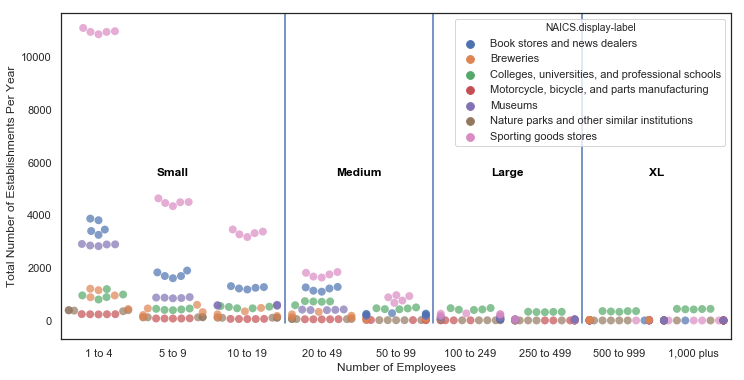

In [11]:
#select data drom 2012 to see how busisnes sizes are distributed among categories
size_group = business[business['EMPSZES.display-label']!='All']
size_group = size_group.groupby(['YEAR.id', 'NAICS.display-label', 'EMPSZES.display-label']).sum()
sizes = size_group.reset_index()

#plot the total number of establishments in each size group for each business type, for each year
plt.figure(figsize = (12, 6))
           
sns.set(style = "white", color_codes = True,  font_scale = 1)

ax = sns.swarmplot(x='EMPSZES.display-label', y = "ESTAB",
              order = ['1 to 4','5 to 9','10 to 19','20 to 49','50 to 99','100 to 249', '250 to 499', '500 to 999','1,000 plus'],
              hue = 'NAICS.display-label', data = sizes, size= 8, alpha = .7)
ax.set(xlabel = "Number of Employees", ylabel = "Total Number of Establishments Per Year")

#create lines where the new groupings will be 
plt.axvline(2.5, .05, 1)
plt.axvline(4.5, .05, 1)
plt.axvline(6.5, .05, 1)

plt.text(1, 5500 ,"Small", horizontalalignment='center', size='medium', color='black', weight='semibold')
plt.text(3.5, 5500, "Medium", horizontalalignment = 'center', size = 'medium', color = 'black', weight = 'semibold' )
plt.text(5.5, 5500, "Large",horizontalalignment = 'center', size = 'medium', color = 'black', weight = 'semibold')
plt.text(7.5, 5500, "XL", horizontalalignment = 'center', size = 'medium', color = 'black', weight = 'semibold')

plt.savefig('sizegroups.png', bbox_inches = 'tight')
plt.show()


##### Demographics: age, population, income

Each category of demographic data - age, population, income - was downloaded as csvs from the Census Bureau’s American Community Survey (ACS). Age data contains the Median Age, female median age, and male median age.Income data contains median and mean household income. Population data contains total estimated population. All of this data is by zip code for years 2012 to 2016.

###### Processing age data

In [6]:
#import age files and add year column

age_12 = pd.read_csv('../capstone_data/beer/Age_ACS_12.csv')
age_12['year']='2012'


age_13 = pd.read_csv('../capstone_data/beer/Age_ACS_13.csv')
age_13['year']='2013'

age_14 = pd.read_csv('../capstone_data/beer/Age_ACS_14.csv')
age_14['year'] = '2014'

age_15 = pd.read_csv('../capstone_data/beer/Age_ACS_15.csv')
age_15['year']='2015'

age_16 = pd.read_csv('../capstone_data/beer/Age_ACS_16.csv')
age_16['year']='2016'

ages = pd.concat([age_12, age_13, age_14, age_15, age_16])

#change column names to ones that make sense
col_names = ['Zip', 'geo','geo_display', 'all_age_median','all_err','male_age_median','male_err','female_age_median','female_err','year']
ages.columns = col_names


# select the last 5 characters of geocode to get zipcode
ages['zipcode']= ages['Zip'].astype(str).str[9:14]
ages = ages.drop(columns = ['Zip','geo','geo_display', 'all_err','female_err','male_err'])
ages = ages.set_index(['year','zipcode'])

ages = ages.apply(pd.to_numeric, errors = 'coerce')


###### Processing income data

In [7]:
#income data 

#import income files seperately, add year column, then combine
income_13 =pd.read_csv('../capstone_data/beer/Income_ACS_13_5YR_S1901.csv')
income_13['year']= '2013'

income_14=pd.read_csv('../capstone_data/beer/Income_ACS_14_5YR_S1901.csv')
income_14['year']='2014'

income_15 = pd.read_csv('../capstone_data/beer/Income_ACS_15_5YR_S1901.csv')
income_15['year']='2015'

income_16 = pd.read_csv('../capstone_data/beer/Income_ACS_16_5YR_S1901_with_ann.csv')
income_16['year']='2016'

income_12 = pd.read_csv('../capstone_data/income/ACS_12_5YR_S1901.csv')
income_12['year']='2012'

income = pd.concat([income_13, income_14, income_15, income_16], sort = True)

#select only useful columns, then change names
income = income[['GEO.id','year','HC01_EST_VC13','HC01_EST_VC15']]
income =pd.concat([income, income_12],sort = True)
income= income.drop(columns = ['GEO.display-label', 'GEO.id2'])
income.columns = ['Zipcode', 'Income_Median', 'Income_Mean', 'Year']

# select the last 5 characters of geocode to get zipcode
income['Zipcode']= income['Zipcode'].astype(str).str[9:14]

#set index, then convert the data to numeric
income = income.set_index(['Year', 'Zipcode'])
income = income.apply(pd.to_numeric, errors = 'coerce')

#since their aren't too many NaN, drop all
#income = income.dropna()

c:\users\sarah robinson\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\sarah robinson\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


###### Processing popoulation data

In [8]:
## population

#import all population csvs
pop_12 = pd.read_csv('../capstone_data/ACS_12_5YR_B01003.csv')
pop_13 = pd.read_csv('../capstone_data/ACS_13_5YR_B01003.csv')
pop_14 = pd.read_csv('../capstone_data/ACS_14_5YR_B01003.csv')
pop_15 = pd.read_csv('../capstone_data/ACS_15_5YR_B01003.csv')
pop_16 = pd.read_csv('../capstone_data/ACS_16_5YR_B01003.csv')

#add year columns 
pop_12['Year']= '2012'
pop_13['Year']= '2013'
pop_14['Year'] = '2014'
pop_15['Year']='2015'
pop_16['Year']= '2016'

#concat data frames into one
pop=pd.concat([pop_12,pop_13,pop_14,pop_15,pop_16], sort = True)

#drop unnecessary columns
pop =pop.drop(columns =['GEO.display-label','GEO.id','HD02_VD01'])

#rename columns and set index
pop.columns = ['Zipcode', 'Population', 'Year']
pop = pop.set_index(['Year','Zipcode'])

#convert to numeric then drop all NaN
pop = pop.apply(pd.to_numeric, errors = 'coerce')
#pop = pop.dropna()

##### GDP per capita
This data set came from the FRED database. GDP per capita is given at state level, for years 2012-2016.

In [ ]:
#import csv
gdp_per = pd.read_csv('../capstone_data/download.csv', header = 4)

# use pd.melt to turn columns of year (2012, 2013, 2014..) into a column, 'year' with years as values
gdp = pd.melt(gdp_per, id_vars = ['Fips','Area'], value_vars = ['2012', '2013', '2014', '2015', '2016'], var_name = 'Year', value_name = 'GDP_per_capita')

#create state code out of Fips
gdp['State_code']= gdp['Fips'].astype(str).str[0:2]

gdp['GDP_per_capita'] = gdp['GDP_per_capita'].apply(pd.to_numeric, errors = 'coerce')

#gdp = gdp.dropna()

##### Industry Contribution to GDP as percent. 
 This data, also from FRED, was orginally displayed as Industry contribution to GDP. To avoid excessive correlation between all of these variables, and to account for inflation, I converted them to percentages of the whole gdp. Because many of the Industry Contribution data had missing entries, I deleted the columns where more than half of the values were null. 

In [ ]:
#import data from FRED of industry gdp by metropolitan area 
orig_gdp_df = pd.read_csv('../capstone_data/allgmp.csv', dtype = str)

# to add years as column 
years = list(orig_gdp_df.columns[8:])
keep = list(orig_gdp_df.columns[0:8])
gdp_pvtdf = pd.melt(orig_gdp_df, id_vars = keep , value_vars = years, var_name = 'Year', value_name = 'GDP by Metro Area')


#drop region column
gdp_dfmin = gdp_pvtdf.drop(columns = ['Region', 'IndustryClassification'])

#to see if 'ComponentName' column is necessary
componentname = gdp_dfmin['ComponentName']
componentname.nunique()
gdp_dfmin['ComponentName'].unique()
gdp_dfmin['ComponentId'].unique()

#convert number columns to float
gdp_dfmin['GDP by Metro Area'] = pd.to_numeric(gdp_dfmin['GDP by Metro Area'], errors = 'coerce')

#to understand 'ComponentName'
gdp_dfmin.ComponentName.value_counts()

#to make a df of only nominal gdp and change header
nominalgdp_df = gdp_dfmin[gdp_dfmin['ComponentId']== '200']
nominalgdp_df = nominalgdp_df.rename(columns = {'GDP by Metro Area':'Nominal GDP'})
nominalgdp_df = nominalgdp_df.drop(columns = ['ComponentId', 'ComponentName'])


#to make a df of only real gdp and change header, this is the gdp I will use for the rest of the data
realgdp_df = gdp_dfmin[gdp_dfmin['ComponentId']== '900']
realgdp_df = realgdp_df.drop(columns = ['ComponentId', 'ComponentName'])
realgdp_df = realgdp_df.rename(columns = {'GDP by Metro Area':'Real GDP'})



#make a df of industry total real gdp
realgdp_df1 = realgdp_df[realgdp_df['IndustryId']=='1']
realgdp_df1 = realgdp_df1.drop(columns = ['GeoName','IndustryId', 'Description'])


#make a dictionary of industry total
my_dict = {}
for index, row in realgdp_df1.iterrows():
    dict2 = {(row['GeoFIPS'], row['Year']): row['Real GDP']}
    my_dict.update(dict2)


#define function that will return percent of total gdp for that year and zip(using dict)
def gdp_percent(row):
    return row['Real GDP']/my_dict[(row['GeoFIPS'], row['Year'])]
    
#use function to create column 'Percent GDP'
realgdp_df['Percent GDP']= realgdp_df.apply(lambda row: gdp_percent(row), axis =1)

#set index as year, geofips, and industry description
ind_gdp = realgdp_df.set_index(['Year','GeoFIPS', 'IndustryId'])

#drop unnessary columns and unstack by industry id
ind_gdp = ind_gdp.drop(columns = ['GeoName', 'Description'])

ind_gdp = ind_gdp.unstack(-1)

#join multilevel columns by '_'
ind_gdp.columns = ['_'.join(col).strip() for col in ind_gdp.columns.values]

#drop years 2001 - 2011
ind_gdp = ind_gdp.drop(index = ['2001','2002','2003','2004','2005','2006','2007','2008','2009','2008','2009','2010','2011'])
#drop US value
ind_gdp = ind_gdp.drop(index = '00998', level = 1)

ind_gdp = ind_gdp.reset_index()

#convert GeoFIPS to string and mame sure all have a len()==5

ind_gdp['GeoFIPS'] = ind_gdp['GeoFIPS'].astype(str)
for code in ind_gdp['GeoFIPS']:
    if len(code)<5:
        print(code)

#drop columns with more than half NaN values
ind_gdp.dropna(thresh=len(ind_gdp)/2, axis=1, inplace=True)

#select only percent gdp from data frame
gdp_cols = [col for col in ind_gdp.columns if 'Real' in col]
gdp_percents = ind_gdp.drop(columns = gdp_cols)
gdp_percents = gdp_percents.set_index(['Year','GeoFIPS'])
ind_pcnt = gdp_percents
#fill na values with median 
#ind_pcnt= gdp_percents.fillna(gdp_percents.median())

In [9]:
industries = realgdp_df[['IndustryId', 'Description']]

NameError: name 'realgdp_df' is not defined

In [ ]:
industries.drop_duplicates(inplace = True)

In [12]:
industry_dict = industries.set_index('IndustryId').to_dict()

In [13]:
industry_dict = industry_dict['Description']

In [14]:
industry_dict.values()

dict_values(['All industry total', ' Private industries', '  Agriculture, forestry, fishing, and hunting', '   Farms', '   Forestry, fishing, and related activities', '  Mining, quarrying, and oil and gas extraction', '   Oil and gas extraction', '   Mining (except oil and gas)', '   Support activities for mining', '  Utilities', '  Construction', '  Manufacturing', '   Durable goods manufacturing', '    Wood product manufacturing', '    Nonmetallic mineral product manufacturing', '    Primary metal manufacturing', '    Fabricated metal product manufacturing', '    Machinery manufacturing', '    Computer and electronic product manufacturing', '    Electrical equipment, appliance, and component manufacturing', '    Motor vehicles, bodies and trailers, and parts manufacturing', '    Other transportation equipment manufacturing', '    Furniture and related product manufacturing', '    Miscellaneous manufacturing', '   Nondurable goods manufacturing', '    Food and beverage and tobacco pro

##### The final(ish) Product
To combine all the data, I first had to create dictionaries using the a table of all geocodes provided by the census. 

In [16]:
#import data on census geocodes in order to combine data with different granularity

geocodes = pd.read_csv('../capstone_data/zip07_cbsa06.txt', 
                       encoding = "ISO-8859-1", dtype = str)

zip2county = pd.read_csv('../capstone_data/zipcode2county.txt', dtype =str)

zip_county = zip2county[['ZCTA5', 'COUNTY']]

zip_county.columns = ['Zipcode','County']

In [17]:
#examine unique values for zip code/CBSA code to determine which is more granular
geocodes['CBSA CODE'].nunique()
geocodes.ZIP5.nunique()

#zipcode is more granular, make a dictionary of zipcode to cbsa
zip_cbsa = geocodes[['ZIP5','CBSA CODE']]
cbsa_dict = zip_cbsa.set_index('ZIP5').to_dict()
cbsa_dict = cbsa_dict['CBSA CODE']

# create a dictionary of zipcode to state
state_zip = geocodes[['ZIP5','STATE CODE']]
state_dict = state_zip.set_index('ZIP5').to_dict()
state_dict = state_dict['STATE CODE']

#create a dictionary of zipcode to county
county_dict = zip_county.set_index('Zipcode').to_dict()
county_dict = county_dict['County']

In [20]:
#reset index to map state values
df = df.reset_index()

df['Zipcode']=df['Zipcode'].astype(str)


#make sure they are all 5 numbers
for code in df['Zipcode']:
    if len(code)<5:
        print(code)

#try again
#add state column to business df with dict
#add state and CBSA code columns to business df with dict
df['State']= df['Zipcode'].map(state_dict)
df['CBSA']= df['Zipcode'].map(cbsa_dict)
df['County'] = df['Zipcode'].map(county_dict)

#now that business data has STATE and CBSA columns, can merge data 

df1 = pd.merge(df, ind_pcnt, left_on = ['Year','CBSA'], right_index=True, how='left')

df2 = pd.merge(df1, income, left_on = ['Year','Zipcode'], right_index = True, how = 'left') 

df3 = pd.merge(df2, ages, left_on = ['Year','Zipcode'], right_index = True, how = 'left')

#pop = pop.set_index(['Year','Zipcode'])

df4 = pd.merge(df3, pop, left_on = ['Year', 'Zipcode'], right_index = True, how = 'left')

df4.head()

gdp.head()

df5 = pd.merge(df4, gdp, left_on = ['Year', 'State'], right_on = ['Year', 'State_code'], how = 'left')

df = df5.set_index(['Year','Zipcode'])

df.head()

level_0  index  \
Year Zipcode                   
2016 28405          0      0   
     28428          1      1   
     28461          2      2   
     28501          3      3   
     28557          4      4   

              Colleges, universities, and professional schools_Large  \
Year Zipcode                                                           
2016 28405                                                  0.0        
     28428                                                  0.0        
     28461                                                  0.0        
     28501                                                  0.0        
     28557                                                  0.0        

              Colleges, universities, and professional schools_XL  \
Year Zipcode                                                        
2016 28405                                                  0.0     
     28428                                                  0.0     
     28461                                                  0.0     
     28501                                                  0.0     
     28557                                                  0.0     

              Book stores and news dealers_All  \
Year Zipcode                                     
2016 28405                                 3.0   
     28428                                 0.0   
     28461                                 0.0   
     28501                                 0.0   
     28557                                 3.0   

              Book stores and news dealers_Small  \
Year Zipcode                                       
2016 28405                                   2.0   
     28428                                   0.0   
     28461                                   0.0   
     28501                                   0.0   
     28557                                   3.0   

              Book stores and news dealers_Medium  \
Year Zipcode                                        
2016 28405                                    1.0   
     28428                                    0.0   
     28461                                    0.0   
     28501                                    0.0   
     28557                                    0.0   

              Book stores and news dealers_Large  \
Year Zipcode                                       
2016 28405                                   0.0   
     28428                                   0.0   
     28461                                   0.0   
     28501                                   0.0   
     28557                                   0.0   

              Book stores and news dealers_XL  Sporting goods stores_All  \
Year Zipcode                                                               
2016 28405                                0.0                        1.0   
     28428                                0.0                        2.0   
     28461                                0.0                        2.0   
     28501                                0.0                        0.0   
     28557                                0.0                        4.0   

                 ...      Income_Median  Income_Mean  all_age_median  \
Year Zipcode     ...                                                   
2016 28405       ...            54449.0      77057.0            40.3   
     28428       ...            61660.0      88926.0            44.7   
     28461       ...            62168.0      87620.0            55.7   
     28501       ...            28529.0      42329.0            44.3   
     28557       ...            51073.0      73444.0            47.4   

              male_age_median  female_age_median  Population   Fips  \
Year Zipcode                                                          
2016 28405               39.6               41.1     31569.0  37000   
     28428               44.3               45.2      6517.0  37000   
     28461               

In [21]:
df.to_csv('../capstone_data/processed_df.csv')